# Cross-lingual Books Alignment With Transformers and OpenVINO™

Cross-lingual text alignment is a task of identifying correspondance between source and target sentences in a pair of texts that are translations of each other. 


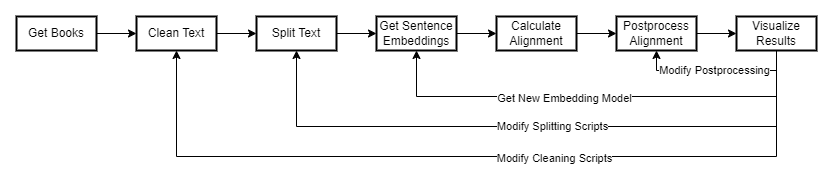

In [1]:
!pip install -q pysbd transformers[torch] openvino_dev>=2023.0 seaborn requests py-gutenberg

## Get The Books

First step is to get books that we will be working with. For this notebook we will use english and german versions of Anna Karenina by Leo Tolstoy. The texts can be obtained from [Project Gutenberg site](https://www.gutenberg.org/). Since the copyright laws are complicated and differ from country to country, check if the book is legal to obtain in your country. You can start with Project Gutenberg Permissions, Licensing and other Common Requests [page](https://www.gutenberg.org/policy/permission.html).

First one needs to find a books on a Project Gutenberg [search page](https://www.gutenberg.org/ebooks/) and get the each book id. To get the texts we will pass ids to the `py-gutenberg` library.

In [5]:
import requests
from gutenberg import GutenbergAPI


def get_book_by_id(book_id: int, api: GutenbergAPI = GutenbergAPI()) -> str:
    book_metadata = api.get_book_text(book_id)
    book_url = book_metadata.formats["text/plain"]
    return requests.get(book_url).text


en_book_id = 1399
de_book_id = 44956

anna_karenina_en = get_book_by_id(en_book_id)
anna_karenina_de = get_book_by_id(de_book_id)

In [6]:
anna_karenina_en[:1500]

'\ufeffThe Project Gutenberg eBook of Anna Karenina, by Leo Tolstoy\r\n\r\nThis eBook is for the use of anyone anywhere in the United States and\r\nmost other parts of the world at no cost and with almost no restrictions\r\nwhatsoever. You may copy it, give it away or re-use it under the terms\r\nof the Project Gutenberg License included with this eBook or online at\r\nwww.gutenberg.org. If you are not located in the United States, you\r\nwill have to check the laws of the country where you are located before\r\nusing this eBook.\r\n\r\nTitle: Anna Karenina\r\n\r\nAuthor: Leo Tolstoy\r\n\r\nRelease Date: July 1, 1998 [eBook #1399]\r\n[Most recently updated: April 9, 2023]\r\n\r\nLanguage: English\r\n\r\n\r\nProduced by: David Brannan, Andrew Sly and David Widger\r\n\r\n*** START OF THE PROJECT GUTENBERG EBOOK ANNA KARENINA ***\r\n\r\n[Illustration]\r\n\r\n\r\n\r\n\r\n ANNA KARENINA \r\n\r\n by Leo Tolstoy \r\n\r\n Translated by Constance Garnett \r\n\r\nContents\r\n\r\n\r\n PART ONE\r\

In [7]:
anna_karenina_de[:1500]

'\ufeffThe Project Gutenberg EBook of Anna Karenina, 1. Band, by Leo N. Tolstoi\r\n\r\nThis eBook is for the use of anyone anywhere at no cost and with\r\nalmost no restrictions whatsoever.  You may copy it, give it away or\r\nre-use it under the terms of the Project Gutenberg License included\r\nwith this eBook or online at www.gutenberg.org\r\n\r\n\r\nTitle: Anna Karenina, 1. Band\r\n\r\nAuthor: Leo N. Tolstoi\r\n\r\nRelease Date: February 18, 2014 [EBook #44956]\r\n\r\nLanguage: German\r\n\r\n\r\n*** START OF THIS PROJECT GUTENBERG EBOOK ANNA KARENINA, 1. BAND ***\r\n\r\n\r\n\r\n\r\nProduced by Norbert H. Langkau, Jens Nordmann and the\r\nOnline Distributed Proofreading Team at http://www.pgdp.net\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n                             Anna Karenina.\r\n\r\n\r\n                        Roman aus dem Russischen\r\n\r\n                                  des\r\n\r\n                         Grafen Leo N. Tolstoi.\r\n\r\n\r\n\r\n                  Nach der siebe

## Clean Text

If you open the downloaded books, you'll see that there are some service information before and after actual text. There are different formatting styles and some markup, for example when the author uses prases from different language, this phrases are enclosed with the underscores (probably to italisize them):

>  Yes, Alabin was giving a dinner on glass tables, and the
tables sang, _Il mio tesoro_—not _Il mio tesoro_ though, but something
better, and there were some sort of little decanters on the table, and
they were women, too,” he remembered.

It will be hard to execute next pipeline stages without clining and text normalization. The particular formating might differ from case to case, so this stage requires manual work. For example, the actual content in german version is enclosed in `*       *       *       *       *`, so it is safe to remove everything before the first and after last astrics.

In [8]:
import re


start_pattern_en = r"\nPART ONE"
anna_karenina_en = re.split(start_pattern_en, anna_karenina_en)[1].strip()

end_pattern_en = "*** END OF THE PROJECT GUTENBERG EBOOK ANNA KARENINA ***"
anna_karenina_en = anna_karenina_en.split(end_pattern_en)[0].strip()

In [9]:
start_pattern_de = "*       *       *       *       *"
anna_karenina_de = anna_karenina_de.split(start_pattern_de, maxsplit=1)[1].strip()
anna_karenina_de = anna_karenina_de.rsplit(start_pattern_de, maxsplit=1)[0].strip()

In [10]:
anna_karenina_en = anna_karenina_en.replace("\r\n", "\n")
anna_karenina_de = anna_karenina_de.replace("\r\n", "\n")

For this notebook we will get just the first chapter.

In [11]:
chapter_pattern_en = r"Chapter \d?\d"
chapter_1_en = re.split(chapter_pattern_en, anna_karenina_en)[1].strip()

In [12]:
anna_karenina_de[:1000]

'Erster Teil.\n\n                               »Die Rache ist mein, ich will vergelten.«\n\n                                   1.\n\n\nAlle glücklichen Familien sind einander ähnlich; jede unglückliche\nFamilie ist auf _ihre_ Weise unglücklich. --\n\nIm Hause der Oblonskiy herrschte allgemeine Verwirrung. Die Dame des\nHauses hatte in Erfahrung gebracht, daß ihr Gatte mit der im Hause\ngewesenen französischen Gouvernante ein Verhältnis unterhalten, und ihm\nerklärt, sie könne fürderhin nicht mehr mit ihm unter einem Dache\nbleiben. Diese Situation währte bereits seit drei Tagen und sie wurde\nnicht allein von den beiden Ehegatten selbst, nein auch von allen\nFamilienmitgliedern und dem Personal aufs Peinlichste empfunden. Sie\nalle fühlten, daß in ihrem Zusammenleben kein höherer Gedanke mehr\nliege, daß die Leute, welche auf jeder Poststation sich zufällig träfen,\nnoch enger zu einander gehörten, als sie, die Glieder der Familie\nselbst, und das im Hause geborene und aufgewachsene G

In [13]:
chapter_pattern_de = r"\d?\d.\n\n"
chapter_1_de = re.split(chapter_pattern_de, anna_karenina_de)[1].strip()

In [14]:
def remove_single_newline(text: str) -> str:
    return re.sub(r"\n(?!\n)", " ", text)

chapter_1_en = remove_single_newline(chapter_1_en)
chapter_1_de = remove_single_newline(chapter_1_de)

In [15]:
def unify_quotes(text: str) -> str:
    return re.sub(r"['\"»«“”]", '"', text)


chapter_1_en = unify_quotes(chapter_1_en)
chapter_1_de = unify_quotes(chapter_1_de)

In [16]:
def remove_markup(text: str) -> str:
    text = text.replace(">=", "").replace("=<", "")
    return re.sub(r"_\w|\w_", "", text)


chapter_1_en = remove_markup(chapter_1_en)
chapter_1_de = remove_markup(chapter_1_de)

Gather clean functions into a single pipeline:

In [17]:
text_cleaning_pipeline = [
    remove_single_newline,
    unify_quotes,
    remove_markup,
]


def clean_text(text: str) -> str:
    progress_bar = tqdm(text_cleaning_pipeline)
    for clean_func in progress_bar:
        progress_bar.set_postfix_str(clean_func.__name__)
        text = clean_func(text)
    return text

## Split Text



In [18]:
import pysbd


splitter_en = pysbd.Segmenter(language="en", clean=True)
sentences_en = splitter_en.segment(chapter_1_en)

In [19]:
splitter_de = pysbd.Segmenter(language="de", clean=True)
sentences_de = splitter_de.segment(chapter_1_de)

In [20]:
len(sentences_en), len(sentences_de)

(32, 34)

## Get Text Embeddings

Next step is to transform sentences into vector representations. Transformer encoder models, such as BERT, provides the best quality embeddings, but can be quite slow. Another aspect is that the model should support both of our chosen languages. In practice, it is quite expensive to train a separete model for each language pair, so there are quite a lot of models pretrained on multiple languages simultaniously, for example:

- multilingual-MiniLM ([example](https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2))
- distiluse-base-multilingual-cased ([example](https://huggingface.co/sentence-transformers/distiluse-base-multilingual-cased-v2))
- bert-base-multilingual-uncased ([example](https://huggingface.co/bert-base-multilingual-uncased))
- LaBSE ([example](https://huggingface.co/rasa/LaBSE))

LaBSE stands for [Language-agnostic BERT Sentence Embedding](https://arxiv.org/pdf/2007.01852.pdf) and supports 109+ languages. It has the same architecture, as BERT model, but was trained on different task - to produce the same embeddings for the translation pair.
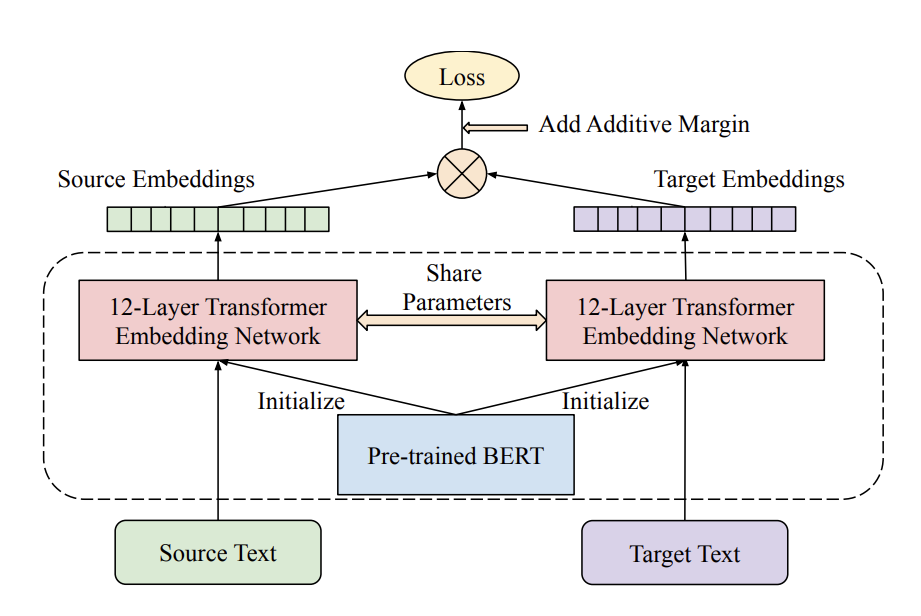

This makes LaBSE model a great choise for our task. More over, the model can be reused for different language pair and still produce the good results.

In [21]:
from typing import List, Union, Dict
from transformers import AutoTokenizer, AutoModel, BertModel
from tqdm.auto import tqdm
import numpy as np
import torch
from openvino.runtime import CompiledModel as OVModel


model_id = "rasa/LaBSE"
pt_model = AutoModel.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)

2023-07-05 12:39:02.069790: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-05 12:39:02.073080: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-05 12:39:02.073093: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [22]:
def get_embeddings(
    sentences: List[str], 
    embedding_model: Union[BertModel, OVModel],
) -> np.ndarray:
    if isinstance(embedding_model, OVModel):
        embeddings = [
            embedding_model(tokenizer(sent, return_tensors="np").data)["last_hidden_state"][0][0]
            for sent in tqdm(sentences)
        ]
        return np.vstack(embeddings)
    else:
        embeddings = [
            embedding_model(**tokenizer(sent, return_tensors="pt"))["last_hidden_state"][0][0]
            for sent in tqdm(sentences)
        ]
        return torch.vstack(embeddings)


embeddings_en_pt = get_embeddings(sentences_en, pt_model)
embeddings_de_pt = get_embeddings(sentences_de, pt_model)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

### Get Embeddings with OpenVINO Model


Lets convert model to OpenVINO and measure the inference speed. [Model Optimizer's Python API](https://docs.openvino.ai/2023.0/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html) accept the LaBSE model object and additional information about model inputs. `example_input` is needed to trace model execution graph, since the PyTorch constructs it dynamicly during inference.

In [23]:
from openvino.runtime import Core, Type
from openvino.tools.mo import convert_model


 # 3 inputs with dynamic axis [batch_size, sequence_length]
inputs_info = [([-1, -1], Type.i64)] * 3 
ov_model = convert_model(
    pt_model,
    example_input=tokenizer("test", return_tensors="pt").data,
    input=inputs_info,
)

core = Core()
compiled_model = core.compile_model(ov_model, "CPU")

embeddings_en = get_embeddings(sentences_en, compiled_model)
embeddings_de = get_embeddings(sentences_de, compiled_model)

/home/apaniuko/python/openvino_notebooks/venv/lib/python3.10/site-packages/torch/jit/annotations.py:309: UserWarning: TorchScript will treat type annotations of Tensor dtype-specific subtypes as if they are normal Tensors. dtype constraints are not enforced in compilation either.
  warnings.warn("TorchScript will treat type annotations of Tensor "


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Using Intel Core i9-10980XE CPU PyTorch model was able to process 32-34 sentences per second, while the same model converted to OpenVINO 53-55 sentences per second. This is more then 50% performance boost with just a few lines of code. Lets check if the model predictions stays within acceptable tolerance:

In [25]:
(
    np.all(np.isclose(embeddings_en, embeddings_en_pt.detach().numpy(), atol=1e-3)),
    np.all(np.isclose(embeddings_de, embeddings_de_pt.detach().numpy(), atol=1e-4)),
)

(True, False)

## Calculate Sentence Alignment

1. Calculate sentence similarity between each pair of sentences
1. Transform values in the similarity matrix rows and columns so that they are in specified range, for example `[-1, 1]`
1. Compare the values with some threshold to get a matricies with 0 and 1
1. Sentence pairs that has 1 in both matricies should be aligned according to the model

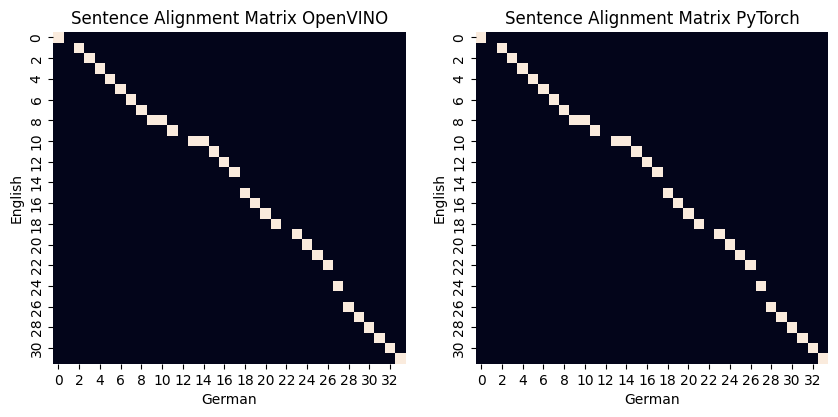

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt


def transform(x):
    x = x - np.mean(x)
    return x / np.var(x)


def calculate_alignment(first: np.ndarray, second: np.ndarray, threshold: float = 1e-3) -> np.ndarray:
    similarity = first @ second.T  # 1
    transform_en_to_de = np.apply_along_axis(transform, -1, similarity)  # 2
    transform_de_to_en = np.apply_along_axis(transform, -2, similarity)  # 2

    softmax_inter = (transform_en_to_de > threshold) * (transform_de_to_en > threshold)  # 3 and 4
    return softmax_inter


threshold = 0.028

alignment_matrix = calculate_alignment(embeddings_en, embeddings_de, threshold)
alignment_matrix_pt = calculate_alignment(
    embeddings_en_pt.detach().numpy(), 
    embeddings_de_pt.detach().numpy(), 
    threshold,
)

_, axis = plt.subplots(1, 2,  figsize=(10, 5))

for matrix, ax, title in zip(
    (alignment_matrix, alignment_matrix_pt), axis, ("OpenVINO", "PyTorch")
):
    plot = sns.heatmap(matrix, cbar=False, square=True, ax=ax)
    plot.set_title(f"Sentence Alignment Matrix {title}")
    plot.set_xlabel("German")
    plot.set_ylabel("English")

In [27]:
def make_alignment(alignment_matrix: np.ndarray) -> Dict[int, List[int]]:
    aligned = {idx: [] for idx, sent in enumerate(sentences_en)}
    for en_idx, de_idx in zip(*np.nonzero(alignment_matrix)):
        aligned[en_idx].append(de_idx)
    return aligned

aligned = make_alignment(alignment_matrix)
aligned

{0: [0],
 1: [2],
 2: [3],
 3: [4],
 4: [5],
 5: [6],
 6: [7],
 7: [8],
 8: [9, 10],
 9: [11],
 10: [13, 14],
 11: [15],
 12: [16],
 13: [17],
 14: [],
 15: [18],
 16: [19],
 17: [20],
 18: [21],
 19: [23],
 20: [24],
 21: [25],
 22: [26],
 23: [],
 24: [27],
 25: [],
 26: [28],
 27: [29],
 28: [30],
 29: [31],
 30: [32],
 31: [33]}

There are several gaps in the resulted alignment. For example, english sentence \#14 did not map to any german one. Posible reasons are:

1. There are no equivalent sentence in the other book. In this case the model works correctly.
1. The sentence has an equivalent sentence in other language, but the model did not catch that. The `threshold` might be too high, or the model is not sensitive enough. Lower the `threshhold` value or try different model.
1. The sentence has an equivalent text part in other language. That means that one of the sentence splitter is working to fine or to coarse. Tune text cleaning and splitting steps to fix this issue.
1. Combination of 2 and 3.

Another solution is to fix the problem after alignment with some heuristics. 

## Visualize Sentence Alignment

To asses the results and 

In [28]:
from IPython.display import display, HTML
from itertools import zip_longest
from io import StringIO


def create_interactive_table(list1, list2, mapping):
    def inverse_mapping(mapping):
        inverse_map = {idx: [] for idx in range(len(list2))}

        for key, values in mapping.items():
            for value in values:
                inverse_map[value].append(key)

        return inverse_map
    
    inversed_mapping = inverse_mapping(mapping)
    
    table_html = StringIO()
    table_html.write('<table id="mappings-table"><tr><th>Sentences EN</th><th>Sentences DE</th></tr>')
    for i, (first, second) in enumerate(zip_longest(list1, list2)):
        table_html.write("<tr>")
        if i < len(list1):
            table_html.write(f'<td id="list1-{i}">{first}</td>')
        else:
            table_html.write("<td></td>")
        if i < len(list2):
            table_html.write(f'<td id="list2-{i}">{second}</td>')
        else:
            table_html.write("<td></td>")
        table_html.write("</tr>")

    table_html.write("</table>")

    hover_script = """
    <script type="module">
      const highlightColor = '#0054AE';
      const textColor = 'white'
      const mappings = {
        'list1': """ + str(mapping) + """,
        'list2': """ + str(inversed_mapping) + """
      };

      const table = document.getElementById('mappings-table');
      let highlightedIds = [];

      table.addEventListener('mouseover', ({ target }) => {
        if (target.tagName !== 'TD' || !target.id) {
          return;
        }

        const [listName, listId] = target.id.split('-');
        const mappedIds = mappings[listName]?.[listId]?.map((id) => `${listName === 'list1' ? 'list2' : 'list1'}-${id}`) || [];
        const idsToHighlight = [target.id, ...mappedIds];

        setBackgroud(idsToHighlight, highlightColor, textColor);
        highlightedIds = idsToHighlight;
      });

      table.addEventListener('mouseout', () => setBackgroud(highlightedIds, ''));

      function setBackgroud(ids, color, text_color="unset") {
        ids.forEach((id) => {
            document.getElementById(id).style.backgroundColor = color;
            document.getElementById(id).style.color = text_color
        });
      }
    </script>
    """
    table_html.write(hover_script)
    return table_html.getvalue()

In [30]:
html_code = create_interactive_table(sentences_en, sentences_de, aligned)
display(HTML(html_code))

Sentences EN,Sentences DE
Happy families are all alike; every unhappy family is unhappy in its own way.,Alle glücklichen Familien sind einander ähnlich; jede unglückliche Familie ist auf hr Weise unglücklich.
Everything was in confusion in the Oblonskys’ house.,--
"The wife had discovered that the husband was carrying on an intrigue with a French girl, who had been a governess in their family, and she had announced to her husband that she could not go on living in the same house with him.",Im Hause der Oblonskiy herrschte allgemeine Verwirrung.
"This position of affairs had now lasted three days, and not only the husband and wife themselves, but all the members of their family and household, were painfully conscious of it.","Die Dame des Hauses hatte in Erfahrung gebracht, daß ihr Gatte mit der im Hause gewesenen französischen Gouvernante ein Verhältnis unterhalten, und ihm erklärt, sie könne fürderhin nicht mehr mit ihm unter einem Dache bleiben."
"Every person in the house felt that there was no sense in their living together, and that the stray people brought together by chance in any inn had more in common with one another than they, the members of the family and household of the Oblonskys.","Diese Situation währte bereits seit drei Tagen und sie wurde nicht allein von den beiden Ehegatten selbst, nein auch von allen Familienmitgliedern und dem Personal aufs Peinlichste empfunden."
"The wife did not leave her own room, the husband had not been at home for three days.","Sie alle fühlten, daß in ihrem Zusammenleben kein höherer Gedanke mehr liege, daß die Leute, welche auf jeder Poststation sich zufällig träfen, noch enger zu einander gehörten, als sie, die Glieder der Familie selbst, und das im Hause geborene und aufgewachsene Gesinde der Oblonskiy."
"The children ran wild all over the house; the English governess quarreled with the housekeeper, and wrote to a friend asking her to look out for a new situation for her; the man-cook had walked off the day before just at dinner time; the kitchen-maid, and the coachman had given warning.","Die Herrin des Hauses verließ ihre Gemächer nicht, der Gebieter war schon seit drei Tagen abwesend."
"Three days after the quarrel, Prince Stepan Arkadyevitch Oblonsky—Stiva, as he was called in the fashionable world—woke up at his usual hour, that is, at eight o’clock in the morning, not in his wife’s bedroom, but on the leather-covered sofa in his study.","Die Kinder liefen wie verwaist im ganzen Hause umher, die Engländerin schalt auf die Wirtschafterin und schrieb an eine Freundin, diese möchte ihr eine neue Stellung verschaffen, der Koch hatte bereits seit gestern um die Mittagszeit das Haus verlassen und die Köchin, sowie der Kutscher hatten ihre Rechnungen eingereicht."
"He turned over his stout, well-cared-for person on the springy sofa, as though he would sink into a long sleep again; he vigorously embraced the pillow on the other side and buried his face in it; but all at once he jumped up, sat up on the sofa, and opened his eyes.","Am dritten Tage nach der Scene erwachte der Fürst Stefan Arkadjewitsch Oblonskiy -- Stiwa hieß er in der Welt -- um die gewöhnliche Stunde, das heißt um acht Uhr morgens, aber nicht im Schlafzimmer seiner Gattin, sondern in seinem Kabinett auf dem Saffiandiwan."
"""Yes, yes, how was it now?"" he thought, going over his dream.","Er wandte seinen vollen verweichlichten Leib auf den Sprungfedern des Diwans, als wünsche er noch weiter zu schlafen, während er von der andern Seite innig ein Kissen umfaßte und an die Wange drückte."


## Speed Up Embeddings Computation



In [46]:
from openvino.runtime import Core, AsyncInferQueue, InferRequest


compiled_throughput_hint = core.compile_model(
    ov_model,
    device_name="CPU",
    config={"PERFORMANCE_HINT":"THROUGHPUT"},
)

In [47]:
all_sentences_en = splitter_en.segment(clean_text(anna_karenina_en))
len(all_sentences_en)

  0%|          | 0/3 [00:00<?, ?it/s]

15778

In [48]:
all_sentences_de = splitter_de.segment(clean_text(anna_karenina_de))
len(all_sentences_de)

  0%|          | 0/3 [00:00<?, ?it/s]

10501

In [49]:
%%timeita
get_embeddings(all_sentences_en[:100], compiled_throughput_hint)

UsageError: Cell magic `%%timeita` not found.


In [50]:
%%timeit
get_embeddings(all_sentences_en[:100], compiled_model)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

1.59 s ± 3.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
def get_embeddings_async(sentences, embedding_model):
    def callback(infer_request, user_data):
        embeddings, idx, pbar = user_data
        embedding = infer_request.get_output_tensor(0).data[0, 0]
        embeddings[idx] = embedding
        pbar.update()


    infer_queue = AsyncInferQueue(embedding_model)
    infer_queue.set_callback(callback)

    embedding_dim = embedding_model.output(0).get_partial_shape().get_dimension(2).get_length()
    embeddings = np.zeros((len(sentences), embedding_dim))
    with tqdm(total=len(sentences)) as pbar:
        for idx, sent in enumerate(sentences):
            tokenized = tokenizer(sent, return_tensors="np").data

            infer_queue.start_async(
                tokenized,
                [embeddings, idx, pbar]
            )

        infer_queue.wait_all()

    return embeddings

In [52]:
%%timeit
get_embeddings_async(all_sentences_en[:100], compiled_model)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

1.55 s ± 4.72 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [53]:
%%timeit
get_embeddings_async(all_sentences_en[:100], compiled_throughput_hint)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

742 ms ± 31.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [490]:
import nncf
from itertools import chain


def transform_fn(text):
    return tokenizer(text, return_tensors="np").data


calibration_dataset = nncf.Dataset(
    chain(all_sentences_en[:150], all_sentences_de[:150]), 
    transform_fn
)

quantized_model = nncf.quantize(
    ov_model, 
    calibration_dataset,
    model_type=nncf.ModelType.TRANSFORMER,
    # fast_bias_correction=True,
    # ignored_scope=ignored_scope,
)

INFO:nncf:201 ignored nodes was found by types in the NNCFGraph
INFO:nncf:24 ignored nodes was found by name in the NNCFGraph
INFO:nncf:Not adding activation input quantizer for operation: 22 aten::rsub_16
INFO:nncf:Not adding activation input quantizer for operation: 25 aten::rsub_17
INFO:nncf:Not adding activation input quantizer for operation: 30 aten::mul_18
INFO:nncf:Not adding activation input quantizer for operation: 11 aten::add_40
INFO:nncf:Not adding activation input quantizer for operation: 14 aten::add__46
INFO:nncf:Not adding activation input quantizer for operation: 17 aten::layer_norm_48
20 aten::layer_norm_49
23 aten::layer_norm_50

INFO:nncf:Not adding activation input quantizer for operation: 36 aten::add_108
INFO:nncf:Not adding activation input quantizer for operation: 55 aten::softmax_109
INFO:nncf:Not adding activation input quantizer for operation: 77 aten::matmul_110
INFO:nncf:Not adding activation input quantizer for operation: 26 aten::add_126
INFO:nncf:Not ad

Biases correction: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 73/73 [00:28<00:00,  2.58it/s]


In [522]:
quantized_throughput_hint = core.compile_model(
    quantized_model,
    device_name="CPU",
    config={"PERFORMANCE_HINT":"THROUGHPUT"},
)

In [523]:
%%timeit
get_embeddings_async(all_sentences_en[:100], quantized_throughput_hint)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

284 ms ± 7.81 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [524]:
embeddings_en = get_embeddings_async(sentences_en, quantized_throughput_hint)
embeddings_de = get_embeddings_async(sentences_de, quantized_throughput_hint)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

31 34 (32, 34)


Text(102.37222222222219, 0.5, 'English')

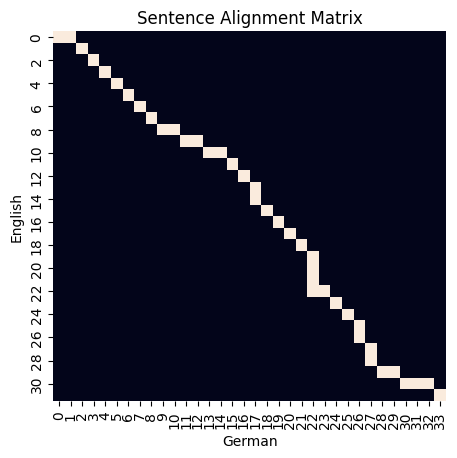

In [526]:
alignment_matrix, m = calculate_alignment(
    embeddings_en,
    embeddings_de,
    threshold=0.09,
)

plot = sns.heatmap(m, cbar=False, square=True)
plot.set_title("Sentence Alignment Matrix")
plot.set_xlabel("German")
plot.set_ylabel("English")

Text(102.37222222222219, 0.5, 'English')

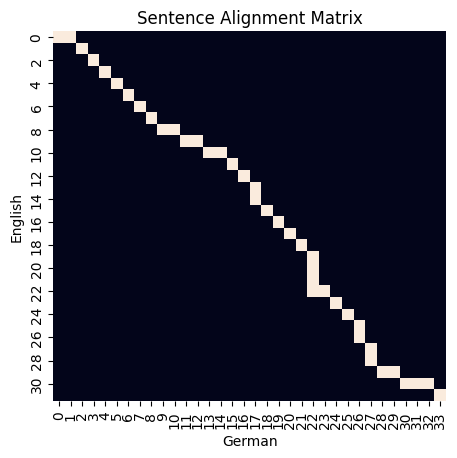

In [527]:
plot = sns.heatmap(m, cbar=False, square=True)
plot.set_title("Sentence Alignment Matrix")
plot.set_xlabel("German")
plot.set_ylabel("English")

In [533]:
aligned

{0: [0, 1],
 1: [2],
 2: [3],
 3: [4],
 4: [5],
 5: [6],
 6: [7],
 7: [8],
 8: [9, 10],
 9: [11, 12],
 10: [13, 14],
 11: [15],
 12: [16],
 13: [17],
 14: [17],
 15: [18],
 16: [19],
 17: [20],
 18: [21],
 19: [22],
 20: [22],
 21: [22],
 22: [22, 23],
 23: [24],
 24: [25],
 25: [26],
 26: [26],
 27: [27],
 28: [27],
 29: [28, 29],
 30: [30, 31, 32],
 31: [33]}

In [530]:
aligned = make_alignment(m)
html_code = create_interactive_table(sentences_en, sentences_de, aligned)
display(HTML(html_code))

Sentences EN,Sentences DE
Happy families are all alike; every unhappy family is unhappy in its own way.,Alle glücklichen Familien sind einander ähnlich; jede unglückliche Familie ist auf hr Weise unglücklich.
Everything was in confusion in the Oblonskys’ house.,--
"The wife had discovered that the husband was carrying on an intrigue with a French girl, who had been a governess in their family, and she had announced to her husband that she could not go on living in the same house with him.",Im Hause der Oblonskiy herrschte allgemeine Verwirrung.
"This position of affairs had now lasted three days, and not only the husband and wife themselves, but all the members of their family and household, were painfully conscious of it.","Die Dame des Hauses hatte in Erfahrung gebracht, daß ihr Gatte mit der im Hause gewesenen französischen Gouvernante ein Verhältnis unterhalten, und ihm erklärt, sie könne fürderhin nicht mehr mit ihm unter einem Dache bleiben."
"Every person in the house felt that there was no sense in their living together, and that the stray people brought together by chance in any inn had more in common with one another than they, the members of the family and household of the Oblonskys.","Diese Situation währte bereits seit drei Tagen und sie wurde nicht allein von den beiden Ehegatten selbst, nein auch von allen Familienmitgliedern und dem Personal aufs Peinlichste empfunden."
"The wife did not leave her own room, the husband had not been at home for three days.","Sie alle fühlten, daß in ihrem Zusammenleben kein höherer Gedanke mehr liege, daß die Leute, welche auf jeder Poststation sich zufällig träfen, noch enger zu einander gehörten, als sie, die Glieder der Familie selbst, und das im Hause geborene und aufgewachsene Gesinde der Oblonskiy."
"The children ran wild all over the house; the English governess quarreled with the housekeeper, and wrote to a friend asking her to look out for a new situation for her; the man-cook had walked off the day before just at dinner time; the kitchen-maid, and the coachman had given warning.","Die Herrin des Hauses verließ ihre Gemächer nicht, der Gebieter war schon seit drei Tagen abwesend."
"Three days after the quarrel, Prince Stepan Arkadyevitch Oblonsky—Stiva, as he was called in the fashionable world—woke up at his usual hour, that is, at eight o’clock in the morning, not in his wife’s bedroom, but on the leather-covered sofa in his study.","Die Kinder liefen wie verwaist im ganzen Hause umher, die Engländerin schalt auf die Wirtschafterin und schrieb an eine Freundin, diese möchte ihr eine neue Stellung verschaffen, der Koch hatte bereits seit gestern um die Mittagszeit das Haus verlassen und die Köchin, sowie der Kutscher hatten ihre Rechnungen eingereicht."
"He turned over his stout, well-cared-for person on the springy sofa, as though he would sink into a long sleep again; he vigorously embraced the pillow on the other side and buried his face in it; but all at once he jumped up, sat up on the sofa, and opened his eyes.","Am dritten Tage nach der Scene erwachte der Fürst Stefan Arkadjewitsch Oblonskiy -- Stiwa hieß er in der Welt -- um die gewöhnliche Stunde, das heißt um acht Uhr morgens, aber nicht im Schlafzimmer seiner Gattin, sondern in seinem Kabinett auf dem Saffiandiwan."
"""Yes, yes, how was it now?"" he thought, going over his dream.","Er wandte seinen vollen verweichlichten Leib auf den Sprungfedern des Diwans, als wünsche er noch weiter zu schlafen, während er von der andern Seite innig ein Kissen umfaßte und an die Wange drückte."
